# GCC's ssc-cdi : tomography pipeline for Cateretê
 
- #### Questions? E-mail gcc@lnls.br
- #### Documentation about the ssc-cdi package: https://gcc.lnls.br/wiki/

## Imports

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import json
import sscCdi
import sscRaft

print(f'sscCdi version: {sscCdi.__version__}')
print(f'sscRaft version: {sscRaft.__version__}')

sscCdi version: 0.6.23
sscRaft version: 2.2.0


## Load dictionary

In [2]:
dic = {}

In [3]:
# dic = json.load(open('/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/inputs/CAT_tomo_inputs.json'))
# dic['processing_steps'] = {}
# dic['processing_steps']['read'] = True
# dic['processing_steps']['sort'] = True
# dic['processing_steps']['crop'] = True
# dic['processing_steps']['equalize2D'] = True
# dic['processing_steps']['unwrap'] = True
# dic['processing_steps']['alignment'] = True
# dic['processing_steps']['tomography'] = True
# dic['processing_steps']['equalize3D'] = True
# dic

# Send new job

In [4]:
# server = sscInstall.connect_server()  

In [5]:
# json_filepath_path = sscCdi.cat_ptycho_processing.save_input_dictionary(dic)
# sscCdi.run_at_cluster(server,json_filepath_path,queue='cat',gpus=dic["GPUs"],cpus=dic["CPUs"],jobName='job',script_path = "/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/ssc-cdi-0.5.1/bin/caterete_tomo.py",slurm_path = '/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/inputs/')

# Run Locally

## Load data

In [6]:
dic["recon_method"]  = "ptycho" # ptycho or pwcdi
dic["contrast_type"] = "complex" # phase, magnitude or complex
dic["sinogram_path"] = "/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/glass_sphere/2023-05-16-15h38m_glass_sphere.hdf5"

In [7]:
dic = sscCdi.define_paths(dic)

In [8]:
obj, angles = sscCdi.read_data(dic)
print(f"Object shape = {obj.shape} \t Number of angles: {angles.shape}")

Object shape = (214, 3479, 3479) 	 Number of angles: (214, 2)


In [9]:
projection = np.sum(obj,axis=0)
print(obj.shape,projection.shape)

(214, 3479, 3479) (3479, 3479)


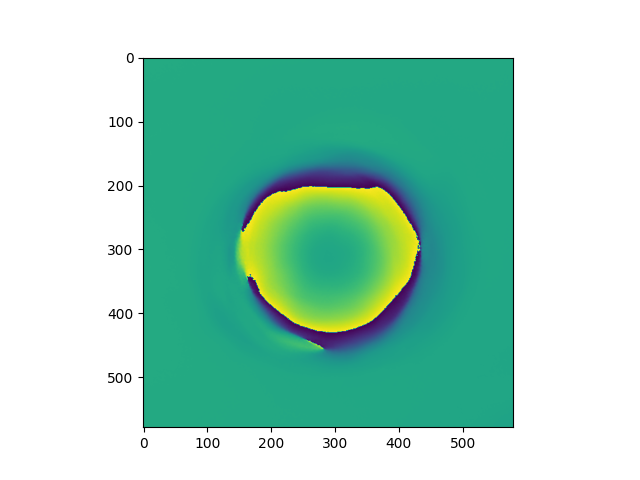

In [53]:
plt.figure()
plt.imshow(np.angle(projection[1500:-1400,1400:-1500]))

In [11]:
# sscCdi.deploy_visualizer(np.angle(obj),title='Original sinogram',cmap='gray')

## Crop data

In [12]:
dic["top_crop"]    = 1500
dic["bottom_crop"] = 1400
dic["left_crop"]   = 1400
dic["right_crop"]  = 1500

In [13]:
sscCdi.tomo_crop(dic,obj)

Cropped sinogram shape: (214, 579, 579)
Time elapsed: 5.27 s


In [14]:
cropped_data = np.load(dic["cropped_sinogram_filepath"])

In [15]:
sscCdi.deploy_visualizer(cropped_data,type='phase',title="Cropped sinogram",cmap='gray')

In [54]:
sscCdi.deploy_visualizer(cropped_data,type='real',title="Cropped sinogram",cmap='gray')

## Sort data

In [17]:
sscCdi.tomo_sort(dic,cropped_data, angles)

Time elapsed: 0.54 s


In [35]:
dic["bad_frames_after_sorting"] = [113]
sscCdi.remove_frames_after_sorting(dic)

Original shape:  (214, 579, 579)
New shape:  (213, 579, 579)


In [36]:
sorted_data = np.load(dic["ordered_object_filepath"])
sscCdi.deploy_visualizer(sorted_data,type='phase',title="Ordered sinogram",cmap='gray')

## Alignment: Cross Correlation (CC) and Vertical Mass Fluctuation (VMF)

In [37]:
aligned_data_CC = sscCdi.alignment_variance_field(sorted_data, fft_upsampling=10,return_common_valid_region=True, remove_null_borders = True)

Finding shift between neighboor slices...
Finding shift between slices #0/213
Finding shift between slices #50/213
Finding shift between slices #100/213
Finding shift between slices #150/213
Finding shift between slices #200/213
Shifting slice #0/213
Shifting slice #50/213
Shifting slice #100/213
Shifting slice #150/213
Shifting slice #200/213


In [38]:
sscCdi.misc.deploy_visualizer(aligned_data_CC,type='phase',title='CC',cmap='gray',axis=0) # select axis

Calculating 1D mass distribution...
Finding shift between neighboor slices...
Shifting slices...
Aligning volume...


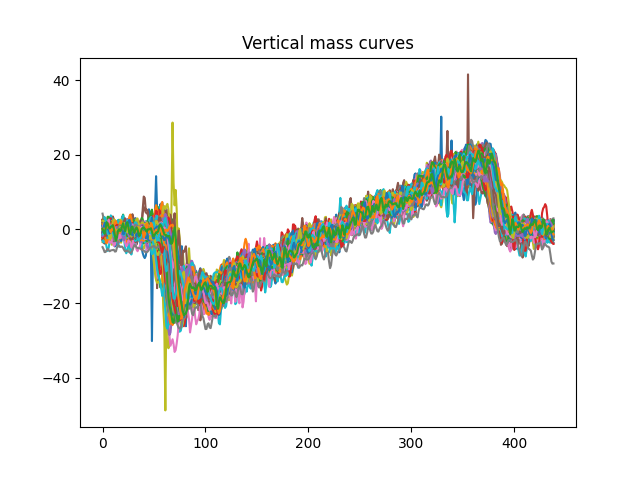

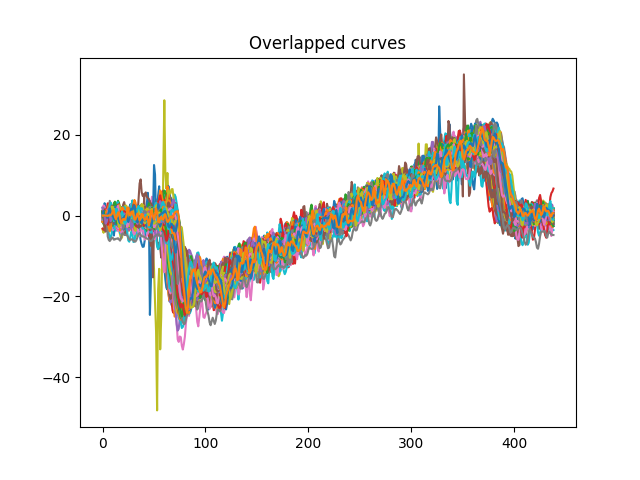

In [39]:
aligned_data_VMF = sscCdi.alignment_vertical_mass_fluctuation(aligned_data_CC, use_phase_gradient = True, return_common_valid_region=True, remove_null_borders = True, plot = True) # if data is not equalized, phase gradient should be used

In [40]:
sscCdi.misc.deploy_visualizer(np.angle(aligned_data_VMF),title='VMF',cmap='gray',axis=0) # select axis

In [41]:
np.save(dic["pre_aligned_sinogram_filepath"],aligned_data_VMF) # select which prealigned dataset to save

## Unwrap

In [42]:
cropped_data = np.load(dic["cropped_sinogram_filepath"])

In [43]:
dic["bad_frames_before_unwrap"] = [28,30,45,49,65,66,91,113]

""" Select data to be unwrapped """
# data_to_unwrap = np.angle(sorted_data)
# data_to_unwrap = np.angle(cropped_data)
data_to_unwrap = np.angle(aligned_data_CC)
# data_to_unwrap = np.angle(aligned_data_VMF)

In [44]:
sscCdi.tomo_unwrap(dic, data_to_unwrap)

Using 32 parallel processes


100%|██████████| 213/213 [00:01<00:00, 137.61it/s]


Time elapsed: 5.76 s


In [45]:
sscCdi.deploy_visualizer(np.load(dic["unwrapped_sinogram_filepath"]),title="Unwrapped sinogram",cmap='gray')

## 2D Equalization

In [46]:
dic["bad_frames_before_equalization"] = []

dic["CPUs"] = 32

dic["equalize_invert"] = True # invert phase shift signal from negative to positive
dic["equalize_ROI"] = [0,100,0,100] # region of interest of null region around the sample used for phase ramp and offset corrections
dic["equalize_remove_phase_gradient"] = True  # if empty and equalize_ROI = [], will subtract best plane fit from whole image
dic["equalize_remove_phase_gradient_iterations"] = 5
dic["equalize_local_offset"] = False # remove offset of each frame from the mean of ROI 
dic["equalize_set_min_max"]= [-5,8] # [minimum,maximum] threshold values for whole volume
dic["equalize_non_negative"] = True # turn any remaining negative values to zero


In [47]:
sinogram_to_equalize = np.load(dic["unwrapped_sinogram_filepath"])
sscCdi.tomo_equalize(dic,sinogram_to_equalize)

Sinogram shape to equalize:  (213, 439, 433)
Using 32 parallel processes


100%|██████████| 213/213 [00:05<00:00, 41.38it/s]


Min 	 Mean-3*sigma 	 Mean 	 Mean+3*sigma 	 Max 
Old -0.81, -5.20, 1.55, 8.31,6.47
New: -1.34, -5.23,1.68, 8.59,7.74
Time elapsed: 11.54 s


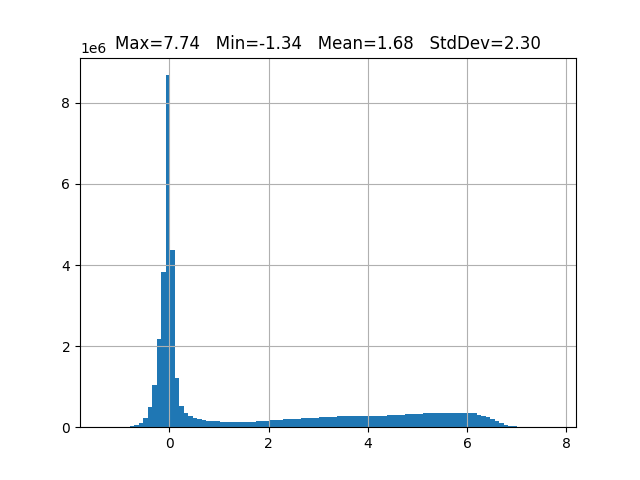

In [48]:
sscCdi.misc.plot_volume_histogram(np.load(dic["equalized_sinogram_filepath"]))

In [49]:
sscCdi.deploy_visualizer(np.load(dic["equalized_sinogram_filepath"]),title="Equalized sinogram",cmap='gray')

In [55]:
sscCdi.deploy_visualizer(np.load(dic["equalized_sinogram_filepath"]),title="Equalized sinogram",cmap='gray',axis=1,aspect_ratio='auto',limits=(-3,4))

In [51]:
sscCdi.deploy_visualizer(np.load(dic["equalized_sinogram_filepath"]),title="Equalized sinogram",cmap='gray',axis=2,aspect_ratio='auto')#,limits=(0,0.5))

## Alignment (wiggle) 

In [ ]:
dic["wiggle_sinogram_selection"] = dic["equalized_sinogram_filepath"]
dic["step_percentage"] = 0 # need to project irregular angle steps to a regular grid?

In [ ]:
sscCdi.preview_angle_projection(dic)

In [ ]:
dic["project_angles_to_regular_grid"] = True 
dic["bad_frames_before_wiggle"] = [] 
dic["wiggle_reference_frame"] = 0 

In [ ]:
dic = sscCdi.tomo_alignment(dic)

In [ ]:
sscCdi.deploy_visualizer(np.load(dic["wiggle_sinogram_filepath"]),title="Aligned sinogram",cmap='gray',axis=1)

## Tomography: select dictionary according to tomographic method
- for details on the tomography algorithm inputs, see documentation at https://gcc.lnls.br/wiki/docs/ssc-raft/reconstructions/

In [ ]:
dic['using_wiggle'] = True

dic['automatic_regularization'] = 0 # skip if 0; regularization between 0 and 1 to enhance borders prior to recon (https://www.sciencedirect.com/science/article/pii/S2590037419300883?via%3Dihub)

# dic["algorithm_dic"] = { # if FBP: filtered back-projection
#     'algorithm': "FBP",
#     'gpu': [0,1],
#     'filter': 'lorentz', # 'gaussian','lorentz','cosine','rectangle'
#     'regularization': 0.1, # 0 <= regularization <= 1; use for smoothening
# }

dic["algorithm_dic"] = { # if eEM: emission expectation maximization
    'algorithm': "EM",
    'gpu': [0,1],
    'regularization': 0.0001,
    'method': 'eEM', 
    'niterations': [20,0,0,0], # [global iterations, iterations EMTV, iterations2 EMTV, Cone-beam integration points]
    'epsilon': 1e-15, #for EMTV only
    'blocksize': 20, # blocks for parallelization
}

In [ ]:
# sinogram = np.load(dic["equalized_sinogram_filepath"])
sinogram = np.load(dic["wiggle_sinogram_filepath"])
recon3D = sscCdi.tomo_recon(dic,sinogram)

In [ ]:
sscCdi.deploy_visualizer(np.load(dic["reconstruction_filepath"]),title="Recon",cmap='gray',axis=0)#,limits=(-1,1))

## 3D Equalization

In [ ]:
dic["tomo_remove_outliers"] = 0
dic["tomo_threshold"] = 20.0
dic["tomo_local_offset"] = [] # [top,bottom,left,right, axis]
dic["tomo_mask"] = []

In [ ]:
sscCdi.tomo_equalize3D(dic)

In [ ]:
sscCdi.deploy_visualizer(np.load(dic["eq_reconstruction_filepath"]),title="Equalized Recon",cmap='gray',axis=0)

In [ ]:
equalized_tomogram = np.load(dic["eq_reconstruction_filepath"])
sscCdi.plot_histograms(recon3D, equalized_tomogram,bins=300)